<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/itsystems/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN as predictor for signal value

In [0]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd

#https://github.com/nerush/aind2-rnn/blob/master/RNN_project.ipynb
#https://www.youtube.com/watch?v=tPYj3fFJGjk

In [67]:
numerator = [1]
denominator = [1, 1]
deltaTime = 0.01
discrete = signal.cont2discrete((numerator, denominator), deltaTime)
print(discrete)

(array([[0.        , 0.00995017]]), array([ 1.        , -0.99004983]), 0.01)


## Preparation

### Pandas function

,0,1
0,0,0
1,1,1
2,2,4
3,3,9


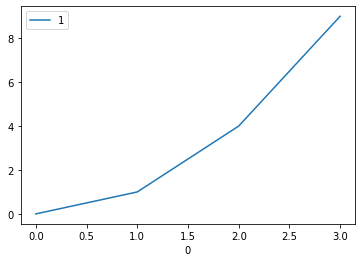

In [138]:
def plotSignal(data, x = 0, y = 1):
  df = pd.DataFrame(data)
  #display(df)
  df.plot.line(x = 0, y = y)

def displaySignal(data):
  df = pd.DataFrame(data)
  display(df)

#example of use
data = [(0, 0), (1, 1), (2, 4), (3, 9)]
plotSignal(data)
displaySignal(data)

### Function for connection of multiple state systems

$F(f_1, f_2, f_3, ..., f_n)(g)=f_n(...f_3(f_2(f_1(g))))$
```python
connect(f1, f2, f3)(g)
```
or
```python
f3(f2(f1(g)))
```

In [0]:
def connect(*F):
  def connected(g):
    result = g
    for f in F:
      result = f(result)
    return result
  return connected

### Time source system

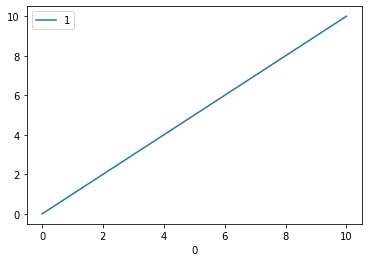

In [125]:
def createTimeGenerator(endTime, startTime = 0, deltaTime = 0.01):
  def time():
    currentTime = startTime
    while True:
      yield (currentTime, currentTime)
      currentTime = currentTime + deltaTime
      if currentTime > endTime:
        break
  return time

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)()
plotSignal(timeFunc)

### Step source system
This is not used in code

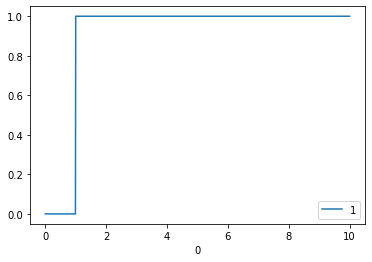

In [128]:
def createStep(stepTime):
  def u(gen):
    for (time, value) in gen:
      if (time < stepTime):
        yield (time, 0)
      else:
        yield (time, 1)
  return u

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)()
step = createStep(1)
plotSignal(step(timeFunc))

### Just 1st order state system 

$\frac{Y(s)}{U(s)}=\frac{K}{Ts+1}$

$Y(s) \cdot (Ts+1)=U(s) \cdot K$

$Ty'(t)+y(t)=Ku(t)$

$y'(t)+\frac{1}{T}y(t)=\frac{K}{T}u(t)$

$y'(t)=\frac{K}{T}u(t)-\frac{1}{T}y(t)$

Euler:

$\lim\limits_{dt \to 0} \frac{y(t+dt)-y(t)}{dt} =\frac{K}{T}u(t)-\frac{1}{T}y(t)$

$\frac{y(t+dt)-y(t)}{dt} =\frac{K}{T}u(t)-\frac{1}{T}y(t)$

$y(t+dt)-y(t) =dt \left( \frac{K}{T}u(t)-\frac{1}{T}y(t) \right)$

$y(t+dt) =y(t) + dt \left( \frac{K}{T}u(t)-\frac{1}{T}y(t) \right)$

,0,1
0,0.00,0.000000
1,0.01,0.000000
2,0.02,0.000000
3,0.03,0.000000
4,0.04,0.000000
...,...,...
996,9.96,0.999878
997,9.97,0.999880
998,9.98,0.999881
999,9.99,0.999882


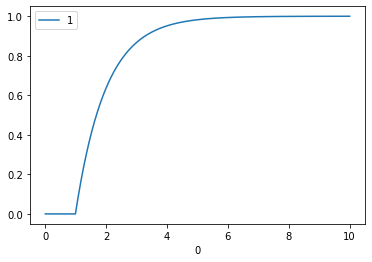

In [130]:
def createFilter1Order(K, T, deltaTime, y0 = 0):
  k1 = K / T
  k2 = 1 / T
  def filter(u):
    currentState = y0
    for time, value in u:
      result = currentState + deltaTime * (k1 * value - k2 * currentState)
      currentState = result
      yield (time, result)
  return filter

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
step = createStep(1)
system = createFilter1Order(1, 1, deltaTime)

simulation = connect(step, system)
plotSignal(simulation(timeFunc()))
displaySignal(simulation(timeFunc()))

### Just 2nd order system

$\frac{Y(s)}{U(s)}=\frac{Ts+1}{As^2+Bs+1}$

$Ay''(t)+By'(t)+y(t)=Tu'(t)+u(t)$

$Ay''(t)=Tu'(t)+u(t)-By'(t)-y(t)$

$Ay''(t)=Tu'(t)-By'(t)+u(t)-y(t)$

$y''(t)=\frac{T}{A}u'(t)-\frac{B}{A}y'(t)+\frac{1}{A}u(t)-\frac{1}{A}y(t)$

$y(t)=x_1(t)$

$x'_1(t)=\frac{T}{A}u(t)-\frac{B}{A}x_1(t) + x_2(t)$

$x'_2(t)=\frac{1}{A}u(t)-\frac{1}{A}x_1(t)$



,0,1
0,0.00,0.000000
1,0.01,0.000000
2,0.02,0.000000
3,0.03,0.000000
4,0.04,0.000000
...,...,...
996,9.96,1.006112
997,9.97,1.006184
998,9.98,1.006255
999,9.99,1.006324


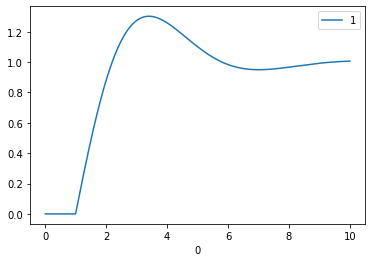

In [131]:
def createFilter2Order(T, A, B, deltaTime, x10 = 0, x20 = 0):
  def filter(u):
    x1 = x10
    x2 = x20
    for time, value in u:
      nx1 = x1 + deltaTime *((T / A) * value - B / A * x1 + x2)
      nx2 = x2 + deltaTime * ((1 / A) * value - 1 / A * x1)
      yield (time, nx1)
      x1 = nx1
      x2 = nx2
  return filter

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
step = createStep(1)
system = createFilter2Order(1, 1, 1, deltaTime)

simulation = connect(step, system)
plotSignal(simulation(timeFunc()))
displaySignal(simulation(timeFunc()))  

### Random signal source

,0,1
0,0.00,0.077096
1,0.01,0.080027
2,0.02,0.020957
3,0.03,0.050815
4,0.04,0.065462
...,...,...
996,9.96,0.370299
997,9.97,0.397415
998,9.98,0.389443
999,9.99,0.353852


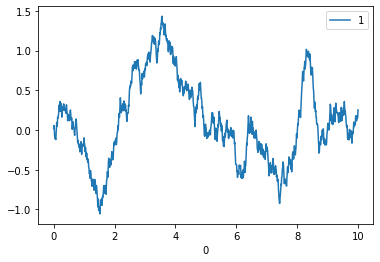

In [132]:
from random import random as rnd
from random import seed
def createRandomSignal(startValue = 0, stepValue = 10):
  def u(gen):
    currentValue = startValue
    for (time, value) in gen:
      r = 2 * rnd() - 1
      yield time, stepValue * r
  return u

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
rSignal = createRandomSignal()
system = createFilter2Order(1, 1, 1, deltaTime)

simulation = connect(rSignal, system)
plotSignal(simulation(timeFunc()))
displaySignal(simulation(timeFunc()))

## Getting data for training
### Signal generation

,0,1
0,0.00,0.001563
1,0.01,-0.006885
2,0.02,-0.025614
3,0.03,-0.019213
4,0.04,-0.030620
...,...,...
1995,19.95,0.035524
1996,19.96,0.029857
1997,19.97,0.034640
1998,19.98,0.025148


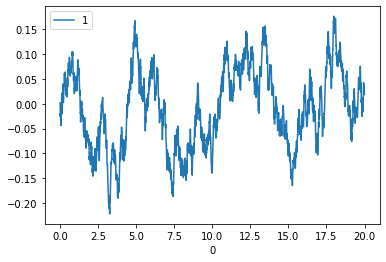

In [133]:
def createFilteredRandomSignal(endTime = 10):
  deltaTime = 0.01
  system = connect(
  #    createStep(stepTime = 1),
      createRandomSignal(10, 1),
      createFilter1Order(2, 1, deltaTime)
  )

  timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = endTime)
  output = list(system(timeFunc()))
  return output

#example of use
seed(30) # important for deterministic results
randomSignal = createFilteredRandomSignal(20)
plotSignal(randomSignal)
displaySignal(randomSignal)

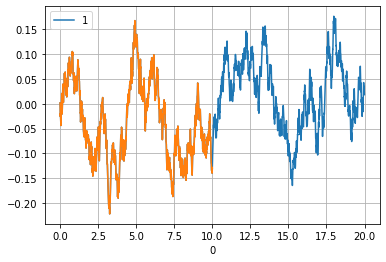

In [116]:

deltaTime = 0.01
endTime = 20

system = connect(
#    createStep(stepTime = 1),
    createRandomSignal(10, 1),
    createFilter1Order(2, 1, deltaTime)
)

timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 10)
output = system(timeFunc())
t = []
y = []
cnt = 1000
#print(next(timeFunc()))
seed(30)
for time, value in output:
  t.append(time)
  y.append(value)

plt.plot(t, y)
plt.grid(which='both')

### Data transformation into training set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.001563,-0.006885,-0.025614,-0.019213,-0.030620,-0.040023,-0.043735,-0.037634,-0.017705,-0.019067,0.000863
1,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,-0.006885,-0.025614,-0.019213,-0.030620,-0.040023,-0.043735,-0.037634,-0.017705,-0.019067,0.000863,0.020557
2,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,-0.025614,-0.019213,-0.030620,-0.040023,-0.043735,-0.037634,-0.017705,-0.019067,0.000863,0.020557,0.010059
3,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,-0.019213,-0.030620,-0.040023,-0.043735,-0.037634,-0.017705,-0.019067,0.000863,0.020557,0.010059,-0.007136
4,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,-0.030620,-0.040023,-0.043735,-0.037634,-0.017705,-0.019067,0.000863,0.020557,0.010059,-0.007136,-0.020669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,19.85,19.86,19.87,19.88,19.89,19.90,19.91,19.92,19.93,19.94,19.95,-0.019775,-0.000727,0.012182,-0.005423,-0.016071,-0.004492,-0.000591,0.018376,0.029343,0.042555,0.035524
1986,19.86,19.87,19.88,19.89,19.90,19.91,19.92,19.93,19.94,19.95,19.96,-0.000727,0.012182,-0.005423,-0.016071,-0.004492,-0.000591,0.018376,0.029343,0.042555,0.035524,0.029857
1987,19.87,19.88,19.89,19.90,19.91,19.92,19.93,19.94,19.95,19.96,19.97,0.012182,-0.005423,-0.016071,-0.004492,-0.000591,0.018376,0.029343,0.042555,0.035524,0.029857,0.034640
1988,19.88,19.89,19.90,19.91,19.92,19.93,19.94,19.95,19.96,19.97,19.98,-0.005423,-0.016071,-0.004492,-0.000591,0.018376,0.029343,0.042555,0.035524,0.029857,0.034640,0.025148


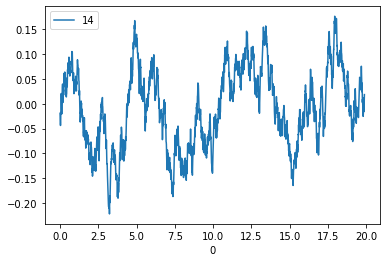

In [140]:
def createWindowFunc(windowSize = 10):
  def windowFunc(gen):
    bufferT = []
    bufferV = []
    for time, value in gen:
      if len(bufferT) == windowSize:
        yield (*bufferT, time, *bufferV, value)
      bufferT.append(time)
      bufferV.append(value)
      if len(bufferT) > windowSize:
        bufferT.pop(0)
        bufferV.pop(0)
  return windowFunc

# example of use  
windowFunc = createWindowFunc(windowSize = 10)
seed(30) # important for deterministic results
randomSignal = createFilteredRandomSignal(20)
windowedData = list(windowFunc(randomSignal)) #list means store data permanently
displaySignal(windowedData)
plotSignal(windowedData, x = 0, y = 14)

In [144]:
def fromOutputToTrain(systemOutput, windowSize = 10):
  windowFunc = createWindowFunc(windowSize)
  windowOutput = windowFunc(systemOutput)
  windowOutputAsDataFrame = pd.DataFrame(windowOutput)
  #display(windowOutputAsDataFrame)
  fromIndex = windowSize + 1
  toIndex = 2 * windowSize + 1
  x_df = windowOutputAsDataFrame[range(fromIndex, toIndex)]
  y_df = windowOutputAsDataFrame[toIndex]
  y_train = y_df.to_numpy() 
  X_train = x_df.to_numpy()
  X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], windowSize, 1)))

  return (X_train, y_train)

# example of use  
seed(30) # important for deterministic results
randomSignal = list(createFilteredRandomSignal(20)) #list means store data permanently
X, y = fromOutputToTrain(randomSignal, windowSize=10)
display(X[:3])
display(y[:3])
#plotSignal(windowedData, x = 0, y = 14)  

array([[[ 0.00156326],
        [-0.00688451],
        [-0.02561419],
        [-0.01921262],
        [-0.03062014],
        [-0.04002286],
        [-0.04373471],
        [-0.03763423],
        [-0.01770544],
        [-0.01906707]],

       [[-0.00688451],
        [-0.02561419],
        [-0.01921262],
        [-0.03062014],
        [-0.04002286],
        [-0.04373471],
        [-0.03763423],
        [-0.01770544],
        [-0.01906707],
        [ 0.000863  ]],

       [[-0.02561419],
        [-0.01921262],
        [-0.03062014],
        [-0.04002286],
        [-0.04373471],
        [-0.03763423],
        [-0.01770544],
        [-0.01906707],
        [ 0.000863  ],
        [ 0.02055725]]])

array([0.000863  , 0.02055725, 0.0100587 ])

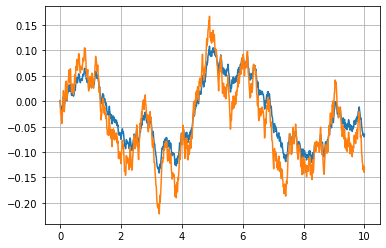

In [75]:
system2 = connect(
#    system,
    createRandomSignal(10, 1),
    createFilter2Order(1, 1, 1, deltaTime = deltaTime)
)
timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 10)
output2 = system2(timeFunc())
t2 = []
y2 = []
seed(30)
tx = list(timeFunc())
for time, value in output2:
  t2.append(time)
  y2.append(value)
plt.plot(t2, y2, t, y)
plt.grid(which='both')


In [0]:
def createWindowFunc(windowSize = 10):
  def windowFunc(gen):
    bufferT = []
    bufferV = []
    for time, value in gen:
      if len(bufferT) == windowSize:
        yield (*bufferT, time, *bufferV, value)
      bufferT.append(time)
      bufferV.append(value)
      if len(bufferT) > windowSize:
        bufferT.pop(0)
        bufferV.pop(0)
  return windowFunc

In [0]:
def window_transform_series(series, windowSize = 10):
    # containers for input/output pairs
    X = [series[i:i + window_size] for i in range(len(series) - window_size)]
    y = series[window_size:]

    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y), 1)

    return X, y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.008879,0.011875,0.016539,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810
1,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.011875,0.016539,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942
2,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.016539,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942,0.038227
3,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942,0.038227,0.041410
4,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942,0.038227,0.041410,0.041622


0    0.047810
1    0.037942
2    0.038227
3    0.041410
4    0.041622
Name: 21, dtype: float64

,11,12,13,14,15,16,17,18,19,20
0,0.008879,0.011875,0.016539,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663
1,0.011875,0.016539,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810
2,0.016539,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942
3,0.019367,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942,0.038227
4,0.025355,0.028711,0.036638,0.040688,0.037075,0.046663,0.047810,0.037942,0.038227,0.041410


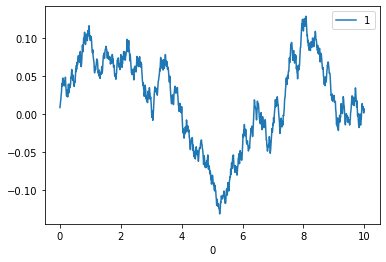

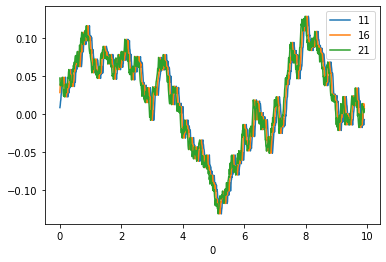

In [77]:
windowSize = 10

system2 = connect(
#    system,
    createRandomSignal(10, 1),
    createFilter2Order(1, 1, 1, deltaTime = deltaTime)
)
timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 10)
output2 = list(system2(timeFunc()))
seed(30)
df = pd.DataFrame(output2) # data to Pandas dataframe
df.plot.line(x=0, y=1) # plot timeline

window = createWindowFunc(windowSize = windowSize) # function for transformation to samples
output3 = list(window(output2)) # samples
df3 = pd.DataFrame(output3) # to dataframe

df3.plot.line(x=0,y=[11,16,21])

x_df = df3[range(11,21)] # select subdataframe (eg. submatrix)
y_df = df3[21] # select subdataframe (eg. submatrix)

#print(output3[0])
#display(df3.to_numpy())
display(df3.head())
display(y_df.head())
display(x_df.head())

#training data
y_train = y_df.to_numpy() 
X_train = x_df.to_numpy()
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], windowSize, 1)))

In [78]:
import numpy as np

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


# and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = [series[i:i + window_size] for i in range(len(series) - window_size)]
    y = series[window_size:]

    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y), 1)

    return X, y


# TODO: build an RNN to perform regression on our time series input/output data
def buildRNN(window_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=5, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dense(units=1))
    return model

output2a = list(map(lambda item: item[0], output2))
print(output2a)
#print(window_transform_series(output2a, windowSize))
model = buildRNN(windowSize)
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0)

[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09, 0.09999999999999999, 0.10999999999999999, 0.11999999999999998, 0.12999999999999998, 0.13999999999999999, 0.15, 0.16, 0.17, 0.18000000000000002, 0.19000000000000003, 0.20000000000000004, 0.21000000000000005, 0.22000000000000006, 0.23000000000000007, 0.24000000000000007, 0.25000000000000006, 0.26000000000000006, 0.2700000000000001, 0.2800000000000001, 0.2900000000000001, 0.3000000000000001, 0.3100000000000001, 0.3200000000000001, 0.3300000000000001, 0.34000000000000014, 0.35000000000000014, 0.36000000000000015, 0.37000000000000016, 0.38000000000000017, 0.3900000000000002, 0.4000000000000002, 0.4100000000000002, 0.4200000000000002, 0.4300000000000002, 0.4400000000000002, 0.45000000000000023, 0.46000000000000024, 0.47000000000000025, 0.48000000000000026, 0.49000000000000027, 0.5000000000000002, 0.5100000000000002, 0.5200000000000002, 0.5300000000000002, 0.5400000000000003, 0.5500000000000003, 0.5600000000000003, 0.57

training error = 3.6195986467646435e-05
3000 2990
testing error = 3.643751551862806e-05


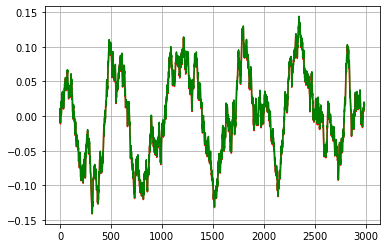

In [104]:
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

def fromOutputToTrain(systemOutput, windowSize = 10):
  windowFunc = createWindowFunc(windowSize)
  windowOutput = windowFunc(systemOutput)
  windowOutputAsDataFrame = pd.DataFrame(windowOutput)
  #display(windowOutputAsDataFrame)
  fromIndex = windowSize + 1
  toIndex = 2 * windowSize + 1
  x_df = windowOutputAsDataFrame[range(fromIndex, toIndex)]
  y_df = windowOutputAsDataFrame[toIndex]
  y_train = y_df.to_numpy() 
  X_train = x_df.to_numpy()
  X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], windowSize, 1)))

  return (X_train, y_train)

X_train, y_train = fromOutputToTrain(output2, windowSize)

#display(y_train)
#display(X_train)

system3 = connect(
#    system,
    createRandomSignal(10, 1),
    createFilter2Order(1, 1, 1, deltaTime = deltaTime)
)
timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 30)
seed(30)
output3 = list(system3(timeFunc()))
X_test, y_test = fromOutputToTrain(output3, windowSize)


print(len(output3),len(X_test))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

test_predict = model.predict(X_test)
#display(test_predict)
plt.plot(y_test, 'r-')
plt.plot(test_predict, 'g-')
plt.grid(which='both')
#pd.DataFrame(output3)#.tail()